Langchain lacks state management , visualization.

Generative AI applications  === > Agentic AI applications

In Generative AI applications , we implemnented rag , tools . agents and messagehistory.

But let say you have task "Plan a economical 5 days trip to France"

This kind of task the llm will be the brain and it will try to use different different tools.

While planning we also need to make sure that the state management should be done . 
like day 2 should consider day 1.

In [43]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state : str

In [44]:
def first_node(state):
    print("My first node is called")
    return { "graph_state" : state["graph_state"] + "I am playing" }

def second_node(state):
    print("My second node is called")
    return { "graph_state" : state["graph_state"] + "Cricket" }

def third_node(state):
    print("My third node is called")
    return { "graph_state" : state["graph_state"] + "Football" }



In [45]:
import random
from typing import Literal

# LITERAL : it specifies the return  (just like constants)

def decide_play(state) -> Literal['second_node' , 'third_node']:
    graph_state = state['graph_state']
    if random.random() < 0.5:
        return "second_node"
    return "third_node"

# since these are two constants which can be returned so we use Literal


In [46]:
from langgraph.graph import StateGraph , START , END

builder = StateGraph(State)
builder.add_node("first_node" , first_node)
builder.add_node("second_node" , second_node)
builder.add_node("third_node" , third_node)

builder.add_edge( START , "first_node" )
builder.add_conditional_edges("first_node" , decide_play)
builder.add_edge("second_node" , END)
builder.add_edge("third_node",END)

graph = builder.compile()

In [47]:
graph.invoke(
    {
        "graph_state" : "Lets start"
    }
)

My first node is called
My third node is called


{'graph_state': 'Lets startI am playingFootball'}

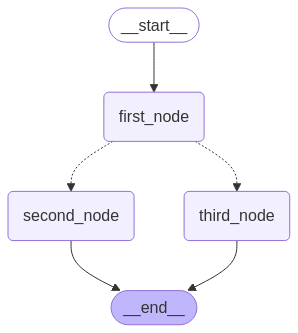

In [48]:
from IPython.display import Image , display

display(
    Image( 
        graph.get_graph().draw_mermaid_png() 
    )
)

# BASIC CHATBOT

In [49]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph , START , END
from langgraph.graph.message import add_messages

In [50]:
class State(TypedDict):
    messages : Annotated[ list , add_messages ] # we are appending not overwriting the new.

In [51]:
import os

from dotenv import load_dotenv
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY


GROQ_API_KEY  = os.getenv("GROQ_API_KEY")
os.environ["GROQ_API_KEY"] = GROQ_API_KEY


In [52]:

from langchain_google_genai import ChatGoogleGenerativeAI 
from langchain_groq import ChatGroq

# llm = ChatGoogleGenerativeAI(model = "gemini-1.5-pro" , temperature = 0 , max_tokens=100)
llm = ChatGroq(model="Gemma2-9b-It")


In [53]:
def chatbot(state : State):
    return { "messages" : [ llm.invoke( state["messages"] ) ] }


In [54]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot" , chatbot)

graph_builder.add_edge(START , "chatbot")
graph_builder.add_edge("chatbot",END)

graph = graph_builder.compile()

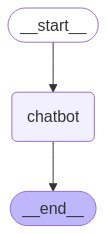

In [55]:
display(
    Image( 
        graph.get_graph().draw_mermaid_png() 
    )
)

# Stream in graph

In [56]:
def stream_graph_updates(user_input : str):
    
    for event in graph.stream( {"messages" : [ { "role" : "user" , "content" : user_input } ] } ) :

        for value in event.values():

            print(" Assistant : " , value["messages"][-1].content)  


In [57]:
while True:

    try:
        user_input = input("User : ")
        if user_input.lower() in ["quit" , "exit" , "q"] : 
            print("Goodbye")
            break
        stream_graph_updates(user_input)

    except:
        user_input = input("what do you know about langgraph")
        print("User : " + user_input)
        stream_graph_updates(user_input)
        break


Goodbye


In [58]:
from pprint import pprint
from langchain_core.messages import AIMessage , HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals" , name = "model") ]
messages.append(HumanMessage(content=f"yes thats right" , model = "Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: model

So you said you were researching ocean mammals
================================ Human Message =================================

yes thats right


In [59]:
def add(a : int ,b : int) -> int:


    """ Add a and b

    Args :

    a : first int
    b : second int
    
    """

    return a + b

In [60]:
llm_with_tools = llm.bind_tools([add])


In [61]:
tool_call = llm_with_tools.invoke([ HumanMessage(content=f"what is 2 plus 3" , name = "Lance") ])

In [62]:
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mf9y', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 975, 'total_tokens': 1061, 'completion_time': 0.156363636, 'prompt_time': 0.04253008, 'queue_time': 0.23253431900000002, 'total_time': 0.198893716}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-09d85c85-94ee-47e8-99fe-e4164e908e1f-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 3}, 'id': 'call_mf9y', 'type': 'tool_call'}], usage_metadata={'input_tokens': 975, 'output_tokens': 86, 'total_tokens': 1061})

In [63]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 3},
  'id': 'call_mf9y',
  'type': 'tool_call'}]

In [64]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

from typing import Annotated
from langgraph.graph.message import add_messages



In [65]:
initial_message = [
    AIMessage(content="hello How can i assist you" , name = "Model"),
    HumanMessage(content="I am looking fo rinformation on generative AI" , name = "Akash" )
]
new_message = AIMessage(content="Hey sure ask me questions my friend" , name="Model")

updated = add_messages(initial_message , new_message)
updated

[AIMessage(content='hello How can i assist you', additional_kwargs={}, response_metadata={}, name='Model', id='f6810c2e-b651-46b2-ad7f-95fbf613fc1f'),
 HumanMessage(content='I am looking fo rinformation on generative AI', additional_kwargs={}, response_metadata={}, name='Akash', id='27c44dbd-965e-493c-bbb6-60253f5f51d8'),
 AIMessage(content='Hey sure ask me questions my friend', additional_kwargs={}, response_metadata={}, name='Model', id='cdf46577-89a0-472d-a302-45c4de0297f1')]

In [66]:

class MessageState(TypedDict):
    messages : Annotated[ list[AnyMessage] , add_messages]


In [67]:
def tool_calling_llm(state : MessageState):
    return { "messages" : [ llm_with_tools.invoke( state["messages"] ) ] }


In [68]:
graph_builder = StateGraph(MessageState)

graph_builder.add_node("LLM_WITH_TOOL_CALL" , tool_calling_llm)

graph_builder.add_edge(START ,"LLM_WITH_TOOL_CALL")
graph_builder.add_edge("LLM_WITH_TOOL_CALL",END)

graph = graph_builder.compile()

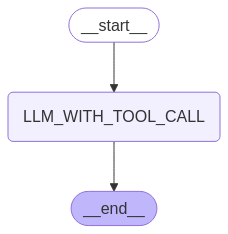

In [69]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [70]:
messages = graph.invoke({ "messages" : [HumanMessage(content="Hello my name is Akash",model = "Akash")] })
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is Akash
================================== Ai Message ==================================
Tool Calls:
  add (call_j205)
 Call ID: call_j205
  Args:
    a: 0
    b: 0


In [71]:
messages = graph.invoke({ "messages" : [HumanMessage(content="what is 2 plus 2",model = "Akash")] })
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (call_1b3w)
 Call ID: call_1b3w
  Args:
    a: 2
    b: 2


hey how to decide tool is work of llm and in this case we are telling multiply but it is adding it 
depends on which llm are you using

In [72]:
messages = graph.invoke({ "messages" : [HumanMessage(content="what is 2 multiply 2",model = "Akash")] })
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

what is 2 multiply 2
================================== Ai Message ==================================
Tool Calls:
  add (call_8xa0)
 Call ID: call_8xa0
  Args:
    a: 2
    b: 2


you can see tool is calling but its not execuing .

In [85]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [86]:
def multiply(a : int ,b : int) -> int :

    """ Multiply a and b

    Args :

    a : first int
    b : second int
    
    """

    return a * b

def sqrt(a : int ) -> int :

    """ Multiply a and a

    Args :

    a : first int

    """

    return a * a

In [87]:
llm_with_tools = llm.bind_tools([multiply,add,sqrt])


In [88]:
graph_builder = StateGraph(MessageState)

graph_builder.add_node("tool_calling_llm" , tool_calling_llm)
graph_builder.add_node("tools" , ToolNode([multiply,add,sqrt]))

graph_builder.add_edge(START , "tool_calling_llm")
graph_builder.add_conditional_edges(
    "tool_calling_llm" ,
    #if the latest message(result) from assistant is tool call -> tool_condition routes to tools
    #if the latest message(result) from assistant is not a tool call -> tool_condition routes to END
    tools_condition
)
graph_builder.add_edge("tools",END)
graph = graph_builder.compile()


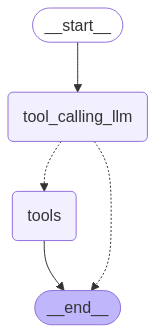

In [89]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [90]:
messages = [HumanMessage(content="what is 2 multiply 2 add 3",model = "Akash")]
messages = graph.invoke({ "messages" : messages })
for m in messages['messages']:
    m.pretty_print()

# Hey you should bind the llm with tool and also you should add ToolNode 
# hey also toocondition directs you to Tools node .(its "Tools" node , so you should name it like only)

================================ Human Message =================================

what is 2 multiply 2 add 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_5g55)
 Call ID: call_5g55
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


In [91]:
messages = [HumanMessage(content="what is 2 multiply 2 add 3 then sqrt it , then multiply it by 5 then add 7 , then sqrt it",model = "Akash")]
messages = graph.invoke({ "messages" : messages })
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 2 multiply 2 add 3 then sqrt it , then multiply it by 5 then add 7 , then sqrt it
================================== Ai Message ==================================
Tool Calls:
  sqrt (call_045y)
 Call ID: call_045y
  Args:
    a: 12.0
================================= Tool Message =================================
Name: sqrt

144


In [92]:
llm_with_tools = llm.bind_tools([multiply,add,sqrt])

In [93]:
graph_builder = StateGraph(MessageState)

graph_builder.add_node("tool_calling_llm1" , tool_calling_llm)
graph_builder.add_node("tool_calling_llm2" , tool_calling_llm)
graph_builder.add_node("tools" , ToolNode([multiply,add,sqrt]))

graph_builder.add_edge(START , "tool_calling_llm1")
graph_builder.add_conditional_edges(
    "tool_calling_llm1" ,
    #if the latest message(result) from assistant is tool call -> tool_condition routes to tools
    #if the latest message(result) from assistant is not a tool call -> tool_condition routes to END
    tools_condition
)
graph_builder.add_edge("tools","tool_calling_llm2")
graph_builder.add_conditional_edges(
    "tool_calling_llm2" ,
    #if the latest message(result) from assistant is tool call -> tool_condition routes to tools
    #if the latest message(result) from assistant is not a tool call -> tool_condition routes to END
    tools_condition
)
graph_builder.add_edge("tools",END)
graph = graph_builder.compile()


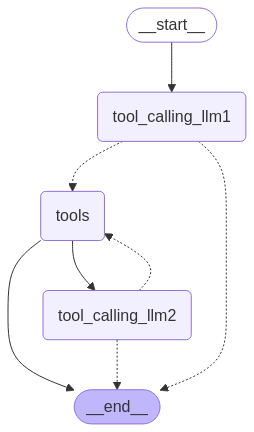

In [94]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [95]:
messages = [HumanMessage(content="what is 2 multiply 2 add 3 then sqrt it",model = "Akash")]
messages = graph.invoke({ "messages" : messages })
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 2 multiply 2 add 3 then sqrt it
================================== Ai Message ==================================
Tool Calls:
  sqrt (call_qcst)
 Call ID: call_qcst
  Args:
    a: 7
================================= Tool Message =================================
Name: sqrt

49
================================== Ai Message ==================================

Okay, so the sqrt of 7 is 2.645751311064591


In [97]:
messages = [HumanMessage(content="what is 2 multiply 2 add 3 then sqrt it and add 7 to it",model = "Akash")]
messages = graph.invoke({ "messages" : messages })
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 2 multiply 2 add 3 then sqrt it and add 7 to it
================================== Ai Message ==================================
Tool Calls:
  sqrt (call_32ew)
 Call ID: call_32ew
  Args:
    a: 11
================================= Tool Message =================================
Name: sqrt

121
================================== Ai Message ==================================
Tool Calls:
  add (call_hzyc)
 Call ID: call_hzyc
  Args:
    a: 121
    b: 7
================================= Tool Message =================================
Name: add

128
================================== Ai Message ==================================

128
